In [24]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img
from tensorflow.keras import backend as K
import keras
from keras.layers import Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, ReLU, Reshape, Dense, Conv2DTranspose, LeakyReLU, Dropout, Flatten
from keras.models import Sequential
from keras.optimizers import Adam

In [25]:
device = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(device[0], True)
device

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Preprocessing

In [26]:
input_shape = (512, 512, 3)
latent_dim = 100
batch_size = 8
data = tf.keras.preprocessing.image_dataset_from_directory(
    "../../../resources/image/paintImg/all_images",
    label_mode=None,
    image_size=(512, 512),
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=True,

)
data

Found 8027 files belonging to 1 classes.


<BatchDataset element_spec=TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None)>

In [27]:
def normalize(image):
    image = tf.cast(image/255. ,tf.float32)
    return image


In [28]:
data = data.map(normalize)

## Model

# Generator


In [61]:
generator = Sequential()
generator.add(Dense(16 * 16 * 512, input_shape=(latent_dim,), activation='relu'))
generator.add(Reshape((16, 16, 512)))
generator.add(BatchNormalization(momentum=0.8))

generator.add(Conv2DTranspose(256, kernel_size=10, strides=2, padding='same'))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dropout(0.25))

generator.add(Conv2DTranspose(128, kernel_size=6, strides=2, padding='same'))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dropout(0.25))

generator.add(Conv2DTranspose(64, kernel_size=6, strides=2, padding='same'))
generator.add(Conv2DTranspose(64, kernel_size=6, padding='same'))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

generator.add(Conv2DTranspose(32, kernel_size=6, strides=2, padding='same'))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dropout(0.25))

generator.add(Conv2DTranspose(16, kernel_size=5, strides=2, padding='same'))
generator.add(Conv2DTranspose(16, kernel_size=5, padding='same'))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

generator.add(Conv2D(3, kernel_size=5, padding='same', activation='sigmoid'))


generator.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 131072)            13238272  
                                                                 
 reshape_6 (Reshape)         (None, 16, 16, 512)       0         
                                                                 
 batch_normalization_51 (Bat  (None, 16, 16, 512)      2048      
 chNormalization)                                                
                                                                 
 conv2d_transpose_55 (Conv2D  (None, 32, 32, 256)      13107456  
 Transpose)                                                      
                                                                 
 leaky_re_lu_50 (LeakyReLU)  (None, 32, 32, 256)       0         
                                                                 
 batch_normalization_52 (Bat  (None, 32, 32, 256)    

# Discriminator

In [62]:
discriminator = Sequential()

discriminator.add(Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=(512, 512, 3)))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))

discriminator.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))

discriminator.add(Conv2D(256, kernel_size=4, strides=2, padding='same'))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))

discriminator.add(Conv2D(512, kernel_size=4, strides=2, padding='same'))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))

discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 256, 256, 64)      3136      
                                                                 
 leaky_re_lu_55 (LeakyReLU)  (None, 256, 256, 64)      0         
                                                                 
 dropout_32 (Dropout)        (None, 256, 256, 64)      0         
                                                                 
 conv2d_28 (Conv2D)          (None, 128, 128, 128)     131200    
                                                                 
 batch_normalization_57 (Bat  (None, 128, 128, 128)    512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_56 (LeakyReLU)  (None, 128, 128, 128)     0         
                                                     

# Model

In [63]:
# https://www.kaggle.com/code/karnikakapoor/art-by-gan?scriptVersionId=84113427&cellId=19
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(seed)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [64]:
epochs = 40
discriminator_opt = Adam(lr=0.0002, beta_1=0.5)
generator_opt = Adam(lr=0.0002, beta_1=0.5)

model = GAN(
    discriminator=discriminator,
    generator=generator,
    latent_dim=latent_dim
)

In [65]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
model.compile(
    d_optimizer=discriminator_opt,
    g_optimizer=generator_opt,
    loss_fn=loss_fn
)

callback = keras.callbacks.EarlyStopping(
    monitor='g_loss',
    patience=2
)


In [ ]:
history = model.fit(data, epochs=epochs, callbacks=[callback])

Epoch 1/40
1004/1004 [==============================] - 659s 654ms/step - d_loss: 0.6523 - g_loss: 1.2431
Epoch 2/40
 928/1004 [==========================>...] - ETA: 43s - d_loss: 0.6111 - g_loss: 1.5194

 # Display performances curves

In [55]:
history_dict = history.history
history_dict

{'d_loss': [0.49414297938346863,
  0.5118855237960815,
  0.5256632566452026,
  0.5442690253257751,
  0.5304863452911377,
  0.47101715207099915],
 'g_loss': [2.228317975997925,
  2.1607980728149414,
  2.0449836254119873,
  1.9405431747436523,
  2.0023465156555176,
  2.491696834564209]}

C:\Users\thorr\AppData\Local\Temp\ipykernel_1648\2905848158.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, g_loss, 'b', label="g_loss", c="red")


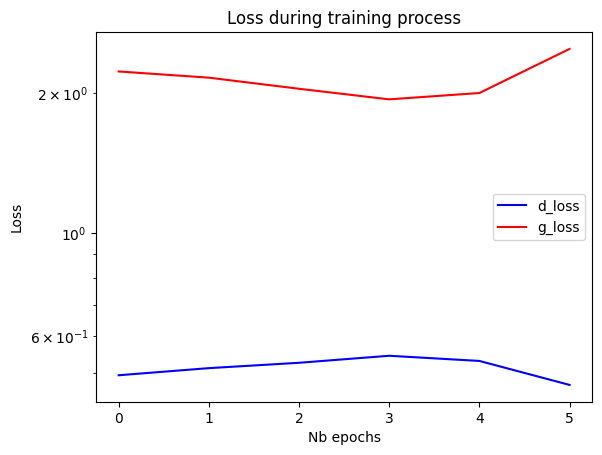

In [58]:
g_loss = history_dict['g_loss']
d_loss = history_dict['d_loss']

epochs = range(6)
plt.plot(epochs, d_loss, 'b', label="d_loss")
plt.plot(epochs, g_loss, 'b', label="g_loss", c="red")
plt.title("Loss during training process")
plt.xlabel("Nb epochs")
plt.ylabel("Loss")
plt.yscale('log')
plt.legend()

In [59]:
num_img=40

#A function to generate and save images
def Potrait_Generator():
    Generated_Paintings = []
    seed = tf.random.normal([num_img, latent_dim])
    generated_image = generator(seed)
    generated_image *= 255
    generated_image = generated_image.numpy()
    for i in range(num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_image[i])
            Generated_Paintings.append(img)
            img.save("Potraits{:02d}.png".format(i))
    return

#Generating images
Images = Potrait_Generator()